In [1]:
import sys
import os

# Add the parent directory (project root) to sys.path
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob

In [3]:
df = pd.read_csv('../data/raw_analyst_ratings.csv')

In [4]:
df.isnull().sum()

Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

In [5]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Add a headline length column
df['headline_length'] = df['headline'].astype(str).apply(len)

# Add weekday column
df['weekday'] = df['date'].dt.day_name()

In [6]:
print(df['headline_length'].describe())

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


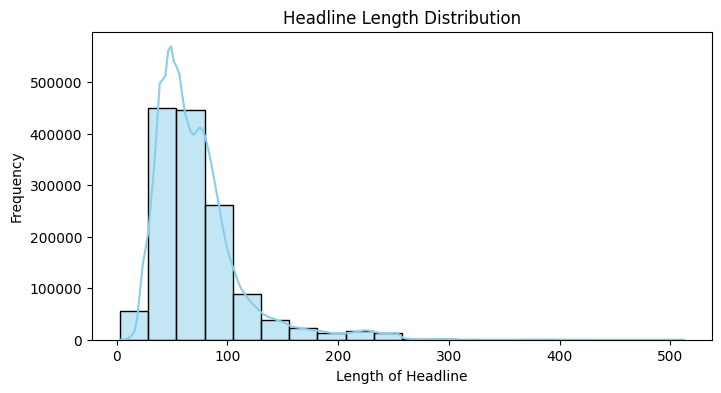

In [7]:
plt.figure(figsize=(8, 4))
sns.histplot(df['headline_length'], bins=20, kde=True, color='skyblue')
plt.title('Headline Length Distribution')
plt.xlabel('Length of Headline')
plt.ylabel('Frequency')
plt.show()

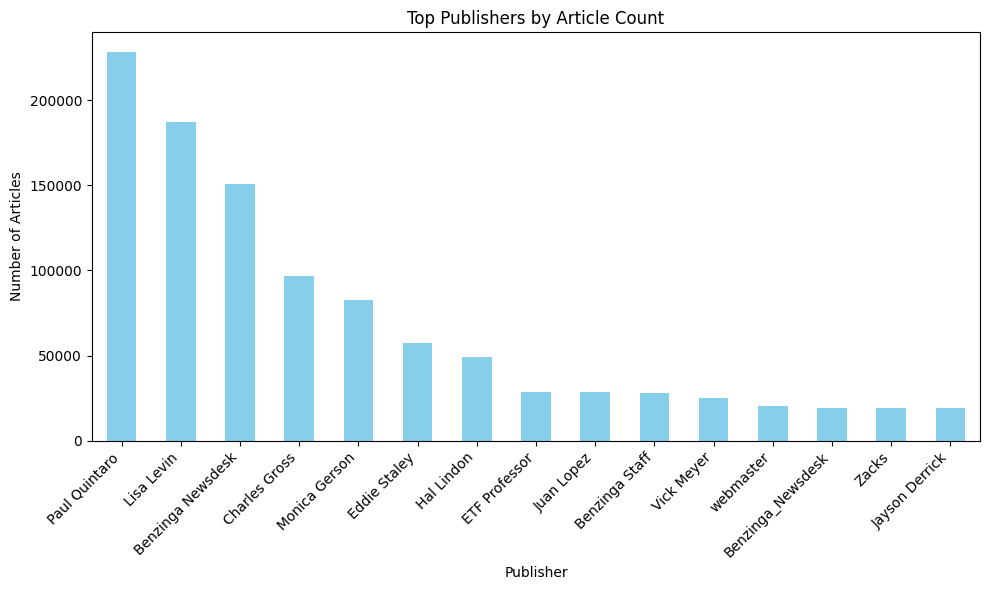

In [8]:
from scripts.publisher_analysis import top_publishers, PublisherPlotter

top_publishers_series = top_publishers(df, n=15)

plotter = PublisherPlotter(top_publishers_series)
plotter.plot_bar()

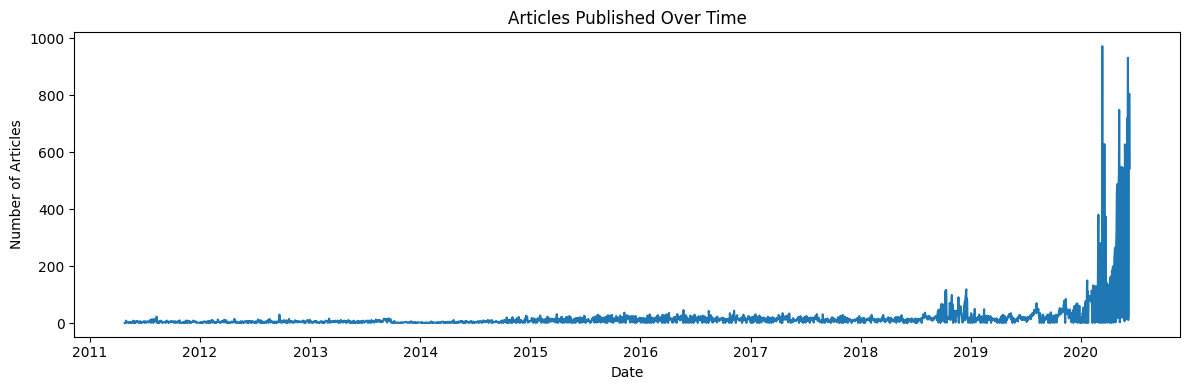

In [9]:
daily_counts = df['date'].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 4))
daily_counts.plot()
plt.title('Articles Published Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()

C:\Users\techin\AppData\Local\Temp\ipykernel_14604\291335989.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_counts.index, y=weekday_counts.values, palette="crest")


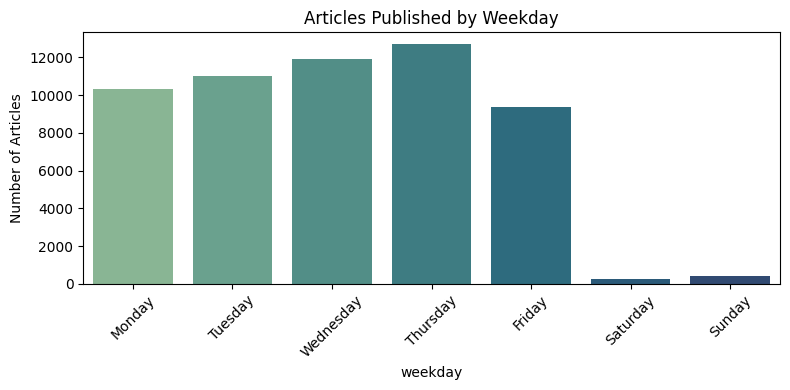

In [10]:
weekday_counts = df['weekday'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(8, 4))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, palette="crest")
plt.title('Articles Published by Weekday')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Text Analysis (Topic Modeling)

In [11]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\techin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [12]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter

# Download necessary NLTK data (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') 

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower() # Lowercase
    text = re.sub(r'[^a-z\s]', '', text) # Remove punctuation and numbers
    tokens = word_tokenize(text) # Tokenize
    tokens = [word for word in tokens if word not in stop_words] # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens] # Lemmatize
    return tokens

df['processed_headline_tokens'] = df['headline'].apply(preprocess_text)
print("Processed Headlines (Tokens):\n", df['processed_headline_tokens'].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\techin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\techin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\techin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\techin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Processed Headlines (Tokens):
 0                     [stock, hit, week, high, friday]
1                  [stock, hit, week, high, wednesday]
2                             [biggest, mover, friday]
3             [stock, moving, friday, midday, session]
4    [b, security, maintains, neutral, agilent, tec...
Name: processed_headline_tokens, dtype: object



Top 20 Most Common Unigrams (Keywords):
 [('stock', 201100), ('v', 162850), ('q', 157942), ('share', 146182), ('est', 140660), ('eps', 128929), ('report', 124503), ('market', 120900), ('update', 93394), ('earnings', 87185), ('sale', 85320), ('top', 81280), ('price', 74211), ('pt', 73144), ('week', 70774), ('buy', 68661), ('lower', 68095), ('announces', 66529), ('company', 65424), ('downgrade', 63812)]

Top 20 Most Common Bigrams (Phrases):
 [(('v', 'est'), 115501), (('q', 'eps'), 81446), (('eps', 'v'), 69970), (('report', 'q'), 67636), (('price', 'target'), 47710), (('benzingas', 'top'), 44258), (('stock', 'moving'), 40092), (('market', 'update'), 33135), (('earnings', 'scheduled'), 32054), (('initiate', 'coverage'), 29040), (('raise', 'pt'), 27268), (('week', 'high'), 26058), (('week', 'low'), 24984), (('share', 'several'), 24080), (('est', 'revenue'), 24024), (('company', 'trading'), 23164), (('trading', 'higher'), 22937), (('hit', 'week'), 21700), (('adj', 'eps'), 21695), (('premar

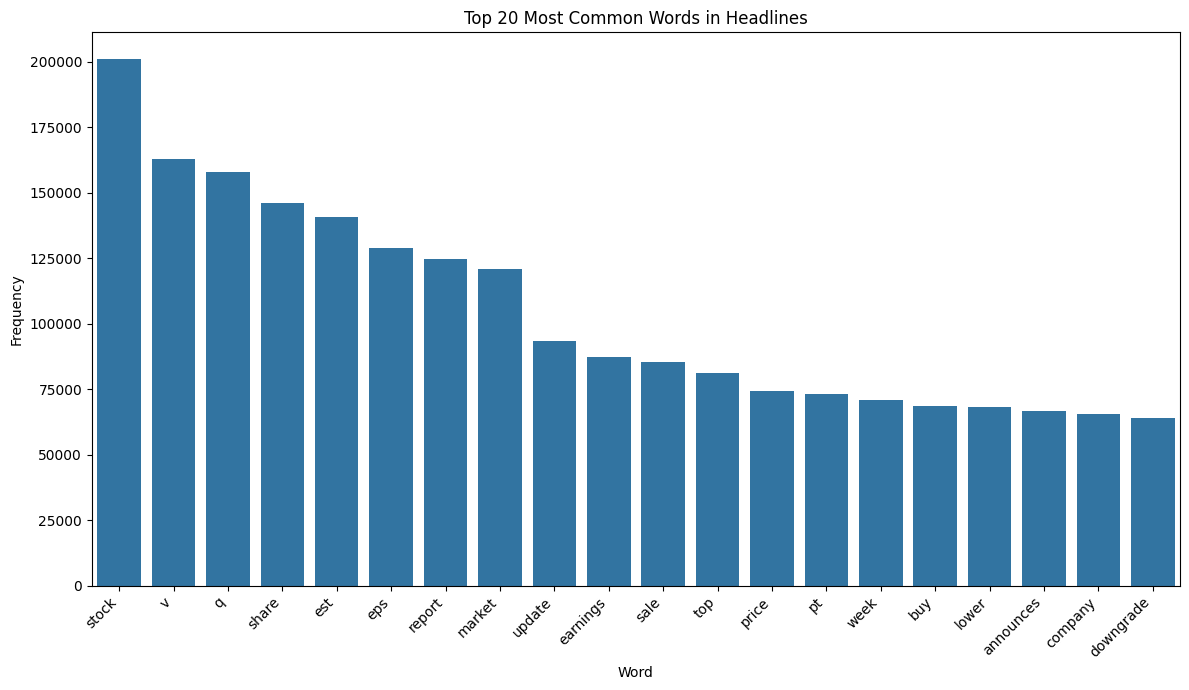

In [18]:
from nltk.util import ngrams
# Flatten the list of lists into a single list of words
all_words = [word for tokens in df['processed_headline_tokens'] for word in tokens]

# Get the most common single words (unigrams)
top_unigrams = Counter(all_words).most_common(20)
print("\nTop 20 Most Common Unigrams (Keywords):\n", top_unigrams)

# Get the most common phrases (bigrams)
def get_top_n_ngrams(corpus, n=2, num_results=None):
    n_grams = []
    for tokens in corpus:
        n_grams.extend(list(ngrams(tokens, n)))
    return Counter(n_grams).most_common(num_results)

# Create a list of tokenized headlines for n-gram analysis
tokenized_headlines_list = df['processed_headline_tokens'].tolist()

top_bigrams = get_top_n_ngrams(tokenized_headlines_list, n=2, num_results=20)
print("\nTop 20 Most Common Bigrams (Phrases):\n", top_bigrams)

top_trigrams = get_top_n_ngrams(tokenized_headlines_list, n=3, num_results=10)
print("\nTop 10 Most Common Trigrams (Phrases):\n", top_trigrams)

# Visualization of top unigrams (optional)
import matplotlib.pyplot as plt
import seaborn as sns

words, counts = zip(*top_unigrams)
plt.figure(figsize=(12, 7))
sns.barplot(x=list(words), y=list(counts))
plt.title('Top 20 Most Common Words in Headlines')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Time series analysis

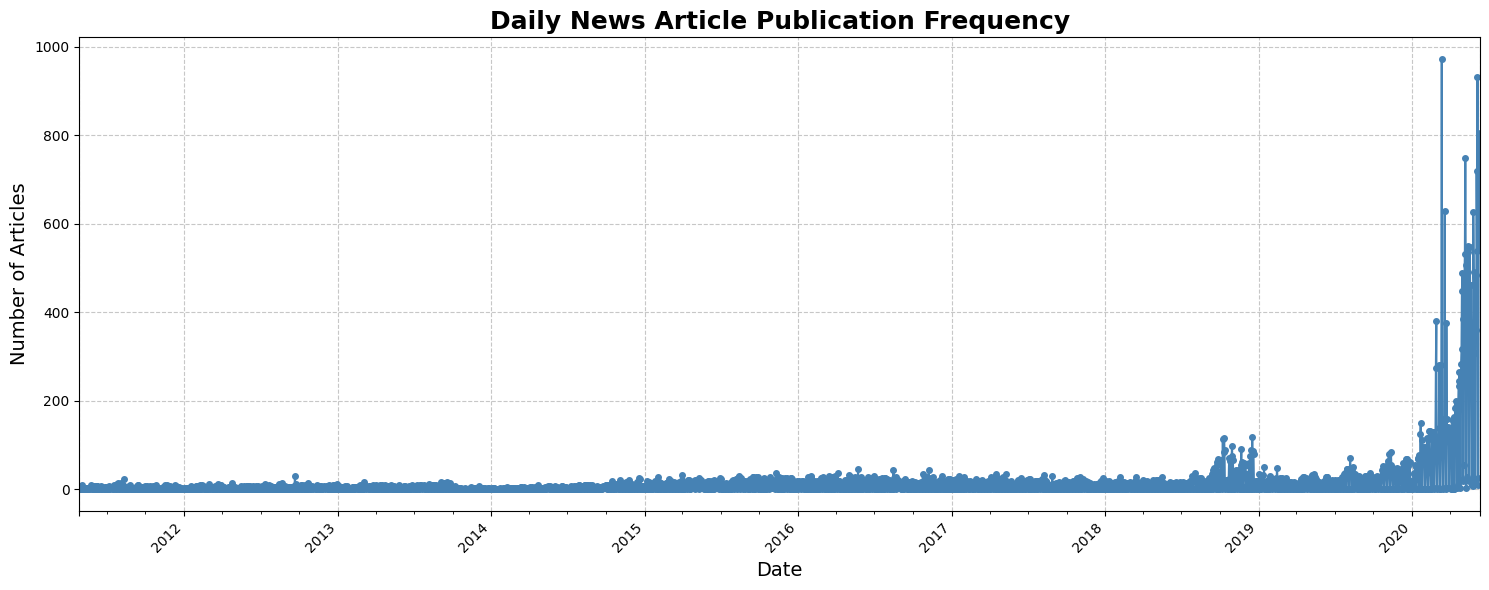

In [13]:
df.set_index('date', inplace=True)

# Resample the DataFrame to a daily frequency ('D') and count the number of articles per day.
daily_counts = df.resample('D').size()

# Plotting the daily publication frequency
plt.figure(figsize=(15, 6)) # Slightly adjusted figure size for better readability
daily_counts.plot(
    kind='line',
    marker='o',       # Add markers to show individual data points
    linestyle='-',    # Connect points with a line
    color='steelblue',# Choose a professional color
    markersize=4,     # Size of the markers
    linewidth=1.5     # Thickness of the line
)

plt.title('Daily News Article Publication Frequency', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7) # Add a subtle grid for easier reading
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better legibility if many dates
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


## Observations from the "Daily News Article Publication Frequency" Plot

- **Long-Term Growth Trend**:  
  From early 2012 to around late 2018/early 2019, the daily publication frequency remains relatively low and stable, often below 100 articles per day. There's a subtle but consistent upward trend.

- **Significant Increase from 2019 Onwards**:  
  Starting in late 2018 or early 2019, there's a noticeable acceleration in the number of daily articles. The baseline frequency appears to shift higher.

- **Explosive Growth and Spikes in 2020**:  
  This is the most striking feature. The year 2020 shows an unprecedented surge in news article publications.

- **Massive Spikes**:  
  There are distinct, very tall spikes, particularly towards the end of 2020, where the daily article count goes from a previous average of perhaps 50–100 to well over 800, even approaching 1000 articles on peak days.

- **Increased Volatility**:  
  Even outside the extreme peaks, the daily volume in 2020 is much higher and more volatile than in previous years.

## Publisher analysis


Top 10 Most Prolific Publishers:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


C:\Users\techin\AppData\Local\Temp\ipykernel_14604\1179246209.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=publisher_counts.index[:10], y=publisher_counts.values[:10], palette='crest')


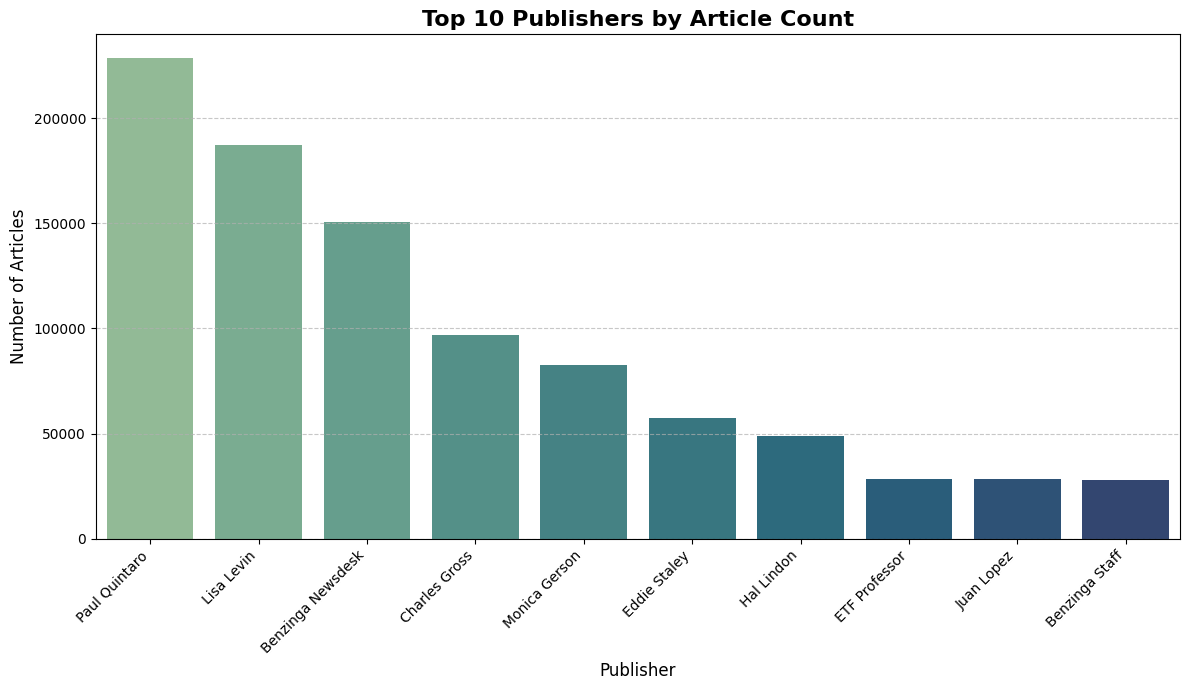

In [15]:
publisher_counts = df['publisher'].value_counts()

print("\nTop 10 Most Prolific Publishers:")
print(publisher_counts.head(10))

# Visualize the top publishers
plt.figure(figsize=(12, 7))
sns.barplot(x=publisher_counts.index[:10], y=publisher_counts.values[:10], palette='crest')
plt.title('Top 10 Publishers by Article Count', fontsize=16, fontweight='bold')
plt.xlabel('Publisher', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
